#Authors: 
- Shubh Pragnesh Shah (2018A7PS0092G)
- Shetty Karan Kavita (2018A7PS0111G)
- Rishit Mayur Patel (2018A7PS0189G)   

As a part of **CS F376** - Emperical Analysis of Approximation Algorithms (under the supervision of  Prof. Pritam Bhattacharya)

# Introduction:
**Set Cover (SC) Problem**:   

- **[Instance]** Set Universe U = {$u_{1}$, $u_{2}$, ... , $u_{n}$} and a family S = {$s_{1}$, $s_{2}$, ... , $s_{n}$} of subsets of U.
- **[Feasible Solutions]** A subfamily C  $\subseteq$ S such that union of C is U.
- **[Value]** The value of a solution is the size of the cover |C|, and the goal is to minimize it.

**Weighted Set Cover Problem**:   

- **[Instance]** Set Universe U = {$u_{1}$, $u_{2}$, ... , $u_{n}$} and a family S = {$s_{1}$, $s_{2}$, ... , $s_{n}$} of subsets of U with a weights array W.
- **[Feasible Solutions]** A subfamily C  $\subseteq$ S such that union of C is U.
- **[Value]** The value of a solution is the weighted sum of the cover: $\sum$ $w_{i}$ for all i such that $S_{i}$ $\epsilon$ C, and the goal is to minimize it.

# Import

In [2]:
import networkx as nx                   
import matplotlib.pyplot as plt 
import pandas as pd
from tabulate import tabulate
import random
import numpy as np
import scipy
from scipy.optimize import linprog
from mpl_toolkits.mplot3d import Axes3D
from math import inf
from math import ceil
import warnings
warnings.filterwarnings("ignore")
import time
import itertools
import copy

In [3]:
!pip install mip
from mip import Model, xsum, minimize, BINARY

# Problem Set Generation
The function generates two sets, that is a universal set (U) of size n and a family of subsets (S) of size m.     
Universal set is given by list [0...n], while we generate the family by randomly deciding if we include a vetex in a subset i or not.   
Thereafter we check if the union gives universal set, if not then we add missed vertices to a randomly chosen subset.

Weights are generated randomly from MIN_WEIGHT to MAX_WEIGHT.

In [4]:
def generate_sets(n,m,PROB = 0.5):
    universal_set = [x for x in range(n)]
    family_of_subsets = [[] for x in range(m)]
    
    for vertex in universal_set: # n
        char_vec = []
        for i in range(m):  # m
            if random.random() >= PROB:
                family_of_subsets[i].append(vertex)

    # Check if union is universal
    union = []
    for i in range(len(family_of_subsets)):
        for vertex in family_of_subsets[i]:
            if vertex not in union:
                union.append(vertex)

    if set(union) == set(universal_set):
        return universal_set,family_of_subsets

    # Add missed vertices to a randomly chosen subset
    diff = list(set(universal_set) - set(union))
    for vertex in diff:
        random_i = random.randint(0,m-1)
        family_of_subsets[random_i].append(vertex)
    return universal_set,family_of_subsets

def generate_weights(family_of_subsets, MIN_WEIGHT = 1, MAX_WEIGHT = 25):
    weights = {}
    for set_i in family_of_subsets:
        # As a list is not hashable, it is coverted to a tuple
        weights[tuple(set_i)] = random.randint(MIN_WEIGHT,MAX_WEIGHT)

    return weights

# Exact Algorithms

## Brute Force

### **Algorithm Brute Force**
**Input:** Universal Set, Family of subsets and a weights array.   
**Output:** A set cover.
1. Iterate through all subsets of Family in order of size.
2. Check if our subset is a set cover.
3. Calculate the cost function and store it's minimum


In [5]:
def check_if_set_cover(universal_set, subsets):
    vertices = []
    for subset in subsets:
        for vertex in subset:
            if vertex not in vertices:
                vertices.append(vertex)
    vertices.sort()
    return (vertices == universal_set) 

class Brute:
    minSize=100000
    set_cover=[]
    all_set_covers = []

def subsets(universal_set, family_of_subsets, weights, brut, ALL = "No"):
    # found = False
    MIN_WEIGHT_SUM = 100000
    for i in range(1,len(family_of_subsets)+1):
        found = 0

        # Generate all subsets of a given length i
        subsets_i = list(itertools.combinations(family_of_subsets, i))
        
        for subset in subsets_i:
            if (check_if_set_cover(universal_set,subset) == True):
                found = 1
                weight_sum = 0
                for sub in (subset):
                    weight_sum += weights[tuple(sub)]
                
                if (weight_sum < MIN_WEIGHT_SUM):
                    MIN_WEIGHT_SUM = weight_sum
                    brut.set_cover = list(subset[:])
                    brut.all_set_covers.clear()
                    brut.all_set_covers.append(brut.set_cover)
                elif (weight_sum == MIN_WEIGHT_SUM):
                    brut.all_set_covers.append(brut.set_cover)
        if found == 1 and (set(weights.values()) == set([1])):
            return

def brute_force(universal_set, family_of_subsets, weights = {}, ALL = "No"): 
    brut = Brute()
    if len(weights) == 0:
        for i in range(len(family_of_subsets)):
            # As a list is not hashable, it is coverted to a tuple
            weights[tuple(family_of_subsets[i])] = 1

    subsets(universal_set, family_of_subsets, weights, brut, ALL) 
    if ALL == "No":
        return brut.set_cover
    else:
        return brut.all_set_covers

## Integer Linear Programming
**Input:** Universal Set(U), Family of subsets(S) and a weights array.   
**Output:** A set cover.

$\begin{align}
\text{min} \quad & \sum_{i = 1}^{m} w_{i} x_{i}, \\
\text{subject to} \\
& \sum_{i:v \in S_{i}} x_{i} \geq 1, \forall \ v\  \in \ U \\
& x_{i} \in \{0,1\} \quad i =1,2,…,n \\
\end{align}$

---

$x_{i} = \begin{cases}
& 1 \quad \text{ if the set S$_{i}$ is included in the set cover, }  \\
& 0 \quad \text{ otherwise}.
\end{cases}$

$w_{i}$ is the weight of the $i^{th}$ set


In [6]:
def ilp(universal_set, family_of_subsets, weights = {}):

    mod = Model("ILP-Set Cover")
    n = len(family_of_subsets)

    # Xi's || set of sets => subsets 
    x = [mod.add_var(var_type=BINARY) for i in range(n)]

    if len(weights) == 0:
        for i in range(n):
            # As a list is not hashable, it is coverted to a tuple
            weights[tuple(family_of_subsets[i])]=1
    mod.objective = minimize(xsum(x[i]*weights[tuple(family_of_subsets[i])] for i in range(n)))

    for element in universal_set:
        mod += xsum(x[i] for i in range(len(family_of_subsets)) if element in family_of_subsets[i]) >= 1

    mod.optimize()

    set_cover = [i for i in range(n) if x[i].x >= 0.99]
    return set_cover

# Approximate Algorithms

## Greedy Algorithm

### **Algorithm G2:**
**Input:** Universal Set(U), Family of subsets(S) and a weights array.   
**Output:** A set cover.

1. Initialize C to an empty set
2. While U is not empty   
    i. Pick a subset with minimum weight/size ratio which belongs to S.     
    ii. Add this subset to C.    
    iii. Remove elements of this subset from the universal set and other subsets in the family of subsets.
3. Return C
---
### **Performance Ratio: O(log(|Family of subsets|))**


In [7]:
def g2_algo(universal_set, family_of_subsets, weights = {}):
    set_cover = []
    # Create a copy and update the copy
    universal_set_copy = copy.deepcopy(universal_set)
    family_of_subsets_copy = copy.deepcopy(family_of_subsets)

    if len(weights) == 0:
        for i in range(len(family_of_subsets)):
            # As a list is not hashable, it is coverted to a tuple            
            weights[tuple(family_of_subsets[i])] = 1

    while (len(universal_set_copy) > 0):
        min_obj = 1000000                       # Weights/Degree
        min_i = -1
        for i in range(len(family_of_subsets_copy)):
            if (len(family_of_subsets_copy[i]) == 0):
                continue
            curr_obj = weights[tuple(family_of_subsets[i])]/len(family_of_subsets_copy[i])
            if curr_obj < min_obj:
                min_obj = curr_obj
                min_i = i
        # Add to Set Cover
        set_cover.append(family_of_subsets[min_i])
        
        # Remove the element from Universal Set
        for element in family_of_subsets_copy[min_i]:
            universal_set_copy.remove(element)

        # Remove the element from other subsets in the family of subsets
        for j in range(len(family_of_subsets)):
            if j != min_i:
                family_of_subsets_copy[j] = [x for x in family_of_subsets_copy[j] if x not in family_of_subsets_copy[min_i]]
            
        family_of_subsets_copy[min_i] = []

    return set_cover

# Functions for Comparision

In [8]:
def plot_ratios(wrt,ratios,lst,ax,title = "Ratio of Length of Set Cover"):
    ratios[wrt] = lst
    df = pd.DataFrame.from_dict(ratios)
    df.columns = df.columns.str.strip()
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    print("\n",title,"vs",wrt)
    print(tabulate(df, headers='keys', showindex = False, tablefmt="psql"))
    del ratios[wrt]
    
    for key in ratios.keys():
        ax.plot(ratios[key], label=key) 
    plt.sca(ax)
    ax.set_xlabel(wrt)
    ax.set_ylabel(title)
    ax.set_title(title+" vs "+wrt)
    plt.xticks(list(range(len(lst))), [ceil(100*x)/100 for x in lst])
    
def plot_3d(title,ps,ns,Z,ax,z_max):
    X, Y = np.meshgrid(ps, ns)  
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_title(title);   
    ax.set_xlabel('P')
    ax.set_ylabel('N')
    ax.set_zlabel('Ratio')
    ax.set_zlim(0, z_max)
    ax.view_init(30, 50)

In [9]:
def compare(universal_set, family_of_subsets, weights = {}, PRINT = False, lp = "none", TIME = False):
    
    WEIGHTED = True
    if len(weights) == 0:
        WEIGHTED = False
        for i in range(len(family_of_subsets)):
            weights[tuple(family_of_subsets[i])] = 1

    t_brute_start = time.time()
    if lp == "ilp":
        set_cover_brute = ilp(universal_set, family_of_subsets, weights)
    else:
        set_cover_brute = brute_force(universal_set, family_of_subsets, weights)
    t_brute_end = time.time()

    t_g2_start = time.time()
    set_cover_g2 = g2_algo(universal_set, family_of_subsets, weights)
    t_g2_end = time.time()
    
    t_brute = t_brute_end - t_brute_start
    t_g2 = t_g2_end - t_g2_start
    
    if TIME == True:
        t_ilp_start = time.time()
        set_cover_ilp = ilp(universal_set, family_of_subsets, weights)
        t_ilp_end = time.time()
        t_ilp = t_ilp_end - t_ilp_start
        time_dict = {'brute':t_brute,'g2':t_g2,'ilp':t_ilp}
        return time_dict

    if len(set_cover_brute) == 0:
        return {'g2':0}

    if WEIGHTED == False:
        g2_ratio = len(set_cover_g2)/len(set_cover_brute)
    else:
        g2_ratio = sum([weights[tuple(x)] for x in set_cover_g2]) / sum([weights[tuple(x)] for x in set_cover_brute])

    if (PRINT):
        info = {}
        info["Vertex Covers"] = [set_cover_brute,set_cover_g2] 
        if WEIGHTED == False:
            info["Length"] = [len(set_cover_brute),len(set_cover_g2)]
        else:
            info["Cost"] = [sum([weights[tuple(x)] for x in set_cover_g2]),sum([weights[tuple(x)] for x in set_cover_brute])]
        
        info["Ratio wrt Brute Force"] = [1,g2_ratio]
        df = pd.DataFrame.from_dict(info)

        if lp == "ilp":
            df.index = ["Integer Lin Prog","G2 Algo"]
        else:
            df.index = ["Brute Force","G2 Algo"]
        df.index.name = "Algorithms"
        print("Comparision of Algorithms")
        print(tabulate(df,headers='keys',tablefmt="psql"))

    ratio_dict = {'g2':g2_ratio}
    return ratio_dict

In [12]:
def compare_algos_n(n_start,n_end,PROB_START,PROB_END,PROB_INC,lp = "none",COMPARE = "size",WEIGHTED = False):
    ns = []
    g2_ratios = []
    brute_ratios = []
    ilp_ratios = []

    for n in range(n_start,n_end+1):
        g2_ratios_p = []
        brute_ratios_p = []
        ilp_ratios_p = []
        prob = PROB_START
        while (prob <= PROB_END+0.001):
            g2_ratio_sum = 0
            brute_ratio_sum = 0
            ilp_ratio_sum = 0
            no = 0
            m_start = n//2
            # m_end = (3*n)//2
            m_end = n**2
            if COMPARE == "time":
                m_end = m_start + 1
            for m in range(m_start,m_end):
                universal_set, family_of_subsets = generate_sets(n,m,prob)
                if WEIGHTED == True:
                    weight_arr = generate_weights(family_of_subsets)
                else:
                    weight_arr = {}
                if COMPARE == "size":
                    ratios = compare(universal_set, family_of_subsets, weight_arr, PRINT = False, lp = lp, TIME = False)
                    g2_ratio = ratios['g2']
                elif COMPARE == "time":
                    ratios = compare(universal_set, family_of_subsets, weight_arr, PRINT = False, lp = lp, TIME = True)
                    g2_ratio = ratios['g2']
                    brute_ratio = ratios['brute']
                    ilp_ratio = ratios['ilp']

                g2_ratio_sum += g2_ratio
                if COMPARE == "time":
                    brute_ratio_sum += brute_ratio
                    ilp_ratio_sum += ilp_ratio
                if (g2_ratio != 0):
                    no += 1
            prob += PROB_INC
            g2_ratios_p.append(g2_ratio_sum/no)
            brute_ratios_p.append(brute_ratio_sum/no)
            ilp_ratios_p.append(ilp_ratio_sum/no)
        ns.append(n)
        g2_ratios.append(g2_ratios_p)
        brute_ratios.append(brute_ratios_p)
        ilp_ratios.append(ilp_ratios_p)

    ms = np.linspace(0.1, 0.95, num = 18)
    g2_ratios = np.array(g2_ratios)

    g2_ratios_m = np.sum(g2_ratios,axis=0)/len(g2_ratios)
    g2_ratios_n = np.sum(g2_ratios,axis=1)/len(g2_ratios[0])
    
    if COMPARE == "time":
        brute_ratios = np.array(brute_ratios)
        brute_ratios_m = np.sum(brute_ratios,axis=0)/len(brute_ratios)
        brute_ratios_n = np.sum(brute_ratios,axis=1)/len(brute_ratios[0])
        ilp_ratios = np.array(ilp_ratios)
        ilp_ratios_m = np.sum(ilp_ratios,axis=0)/len(ilp_ratios)
        ilp_ratios_n = np.sum(ilp_ratios,axis=1)/len(ilp_ratios[0])

    fig = plt.figure(figsize=(20,7))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    ratios_m = {"g2":g2_ratios_m}
    ratios_n = {"g2":g2_ratios_n}
    title = "Ratio of set Covers"
    if COMPARE == "time":
        ratios_m["brute"] = brute_ratios_m
        ratios_n["brute"] = brute_ratios_n
        ratios_m["ilp"] = ilp_ratios_m
        ratios_n["ilp"] = ilp_ratios_n
        title = "Time taken"
    
    plot_ratios("P",ratios_m,ms,ax1,title)
    plot_ratios("N",ratios_n,ns,ax2,title)
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels)  
    fig.show()

    no_of_plots = 1
    z_max = 2
    if COMPARE == "time":
        z_max = 0.0005
        no_of_plots = 3
    fig = plt.figure(figsize=(6,6))
    ax1 = fig.add_subplot(1, no_of_plots, 1,projection='3d')
    if COMPARE == "time":
        ax2 = fig.add_subplot(1, no_of_plots, 2, projection='3d')
        ax3 = fig.add_subplot(1, no_of_plots, 3, projection='3d')
    plot_3d('G2',ms,ns,g2_ratios,ax1,z_max)
    if COMPARE == "time":
        plot_3d('Brute',ms,ns,brute_ratios,ax2,z_max)
        plot_3d('ILP',ms,ns,ilp_ratios,ax3,z_max)
    fig.show()

# Example Instance

In [11]:
example_universal_set = [1,2,3,4,5]
example_family_of_subsets = [[4,1,3],[2,5],[1,4,3,2]]
example_weights = {(4,1,3):5,(2,5):10,(1,4,3,2): 3}

print("Unweighted:")
_ = compare(example_universal_set, example_family_of_subsets, {}, PRINT = True)

print("\n\nWeighted:")
_ = compare(example_universal_set, example_family_of_subsets, example_weights, PRINT = True)

Unweighted:
Comparision of Algorithms
+--------------+------------------------+----------+-------------------------+
| Algorithms   | Vertex Covers          |   Length |   Ratio wrt Brute Force |
|--------------+------------------------+----------+-------------------------|
| Brute Force  | [[4, 1, 3], [2, 5]]    |        2 |                       1 |
| G2 Algo      | [[1, 4, 3, 2], [2, 5]] |        2 |                       1 |
+--------------+------------------------+----------+-------------------------+


Weighted:
Comparision of Algorithms
+--------------+------------------------+--------+-------------------------+
| Algorithms   | Vertex Covers          |   Cost |   Ratio wrt Brute Force |
|--------------+------------------------+--------+-------------------------|
| Brute Force  | [[2, 5], [1, 4, 3, 2]] |     13 |                       1 |
| G2 Algo      | [[1, 4, 3, 2], [2, 5]] |     13 |                       1 |
+--------------+------------------------+--------+---------------

# Comparision of Algorithms

## Unweighted Set Cover

### Execution Time


 Time taken vs P
+------+-------------+-------------+------------+
|    P |          g2 |       brute |        ilp |
|------+-------------+-------------+------------|
| 0.1  | 0.000235172 | 0.000287716 | 0.00822513 |
| 0.15 | 0.000215402 | 0.000396151 | 0.0087439  |
| 0.2  | 0.000201464 | 0.000477479 | 0.00902086 |
| 0.25 | 0.000198548 | 0.000494737 | 0.00909767 |
| 0.3  | 0.000190478 | 0.000423844 | 0.00840007 |
| 0.35 | 0.000187241 | 0.000808386 | 0.0150786  |
| 0.4  | 0.000180254 | 0.0012081   | 0.0116442  |
| 0.45 | 0.00018007  | 0.00150101  | 0.0106212  |
| 0.5  | 0.000165655 | 0.00163153  | 0.00777213 |
| 0.55 | 0.000168443 | 0.00261788  | 0.00727477 |
| 0.6  | 0.000156238 | 0.00313492  | 0.0082719  |
| 0.65 | 0.000156072 | 0.00450732  | 0.00901808 |
| 0.7  | 0.000155146 | 0.00920075  | 0.00602305 |
| 0.75 | 0.000155889 | 0.0164153   | 0.0055543  |
| 0.8  | 0.000142492 | 0.0193615   | 0.00485862 |
| 0.85 | 0.000144592 | 0.0277772   | 0.0045205  |
| 0.9  | 0.000157292 | 0.0255297

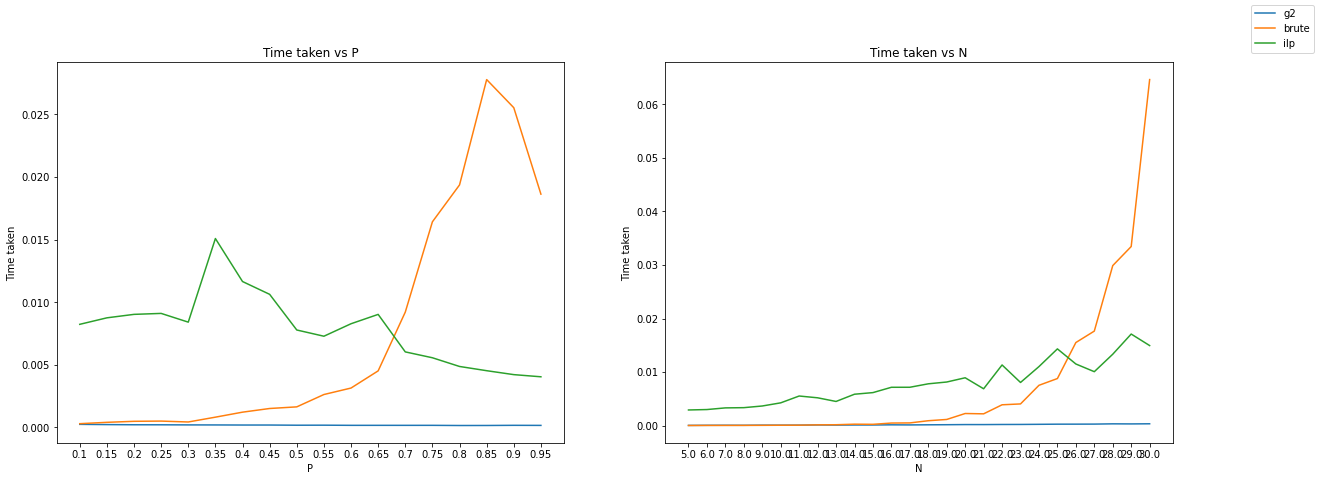

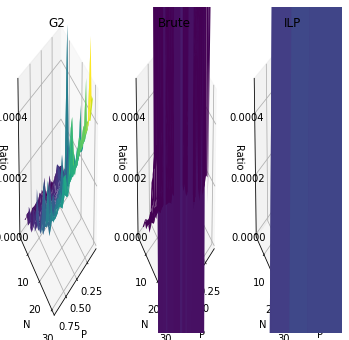

In [43]:
compare_algos_n(5, 30, 0.1, 0.95, 0.05, lp="none", COMPARE = "time", WEIGHTED = False)

### Performance Ratios

In [ ]:
compare_algos_n(5, 10, 0.1, 0.95, 0.05, lp = "none", COMPARE = "size", WEIGHTED = False)

## Weighted Set Cover

### Performance Ratios

In [ ]:
compare_algos_n(5, 10, 0.1, 0.95, 0.05, lp = "none", COMPARE = "size", WEIGHTED=True)